# Applied data analysis
## Self-confidence through quotations:



### Mount the Google Drive in order to access to the files which are located on our drive


In [2]:
from google.colab import drive
drive._mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AX4XfWj-TqOJX5I2y6IAOE32hItMg8jxMn-OsK7JVGupKgBrIrg_WJAXmac
Mounted at /content/drive


### Install and import every packages that will be necessary for the analysis

In [3]:
!pip install pickle-mixin
!pip install pyarrow
!pip install pathlib


import pyarrow
import pandas as pd
import numpy as np
import pathlib
from datetime import datetime
import sys
import bz2
import json
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

  Created wheel for pickle-mixin: filename=pickle_mixin-1.0.2-py3-none-any.whl size=6008 sha256=440893bca8f20ac4fdb987aba85fd4e0cf5e17d784dd1028215a7f4a356d59c3
  Stored in directory: /root/.cache/pip/wheels/d0/70/0b/673e09a7ed429660d22352a1b117b4f616a8fc054bdd7eb157
Successfully built pickle-mixin


##Pre process of the data



In [4]:
# The following function allows to only keep the attributes when a single evalue is given. 
#The function replaces array of size 1 by its first element
#Indeed, some attributes are associated with an array of value, to make sure that the value we will use is the correct one, 
#we simple get rid of multiple valued element by replacing them with a 'Nan' value.

def rem_mult(array):
  if isinstance(array, np.ndarray):
    if array.size == 1 :
      array = array[0]
    else :
      array = np.nan
  return array


#### Extracting the relevant data from the original files and saving them in a new file


In [5]:
path_to_file = '/content/drive/MyDrive/ADAprojet2021/Quotebank/quotes-2020.json.bz2' 
path_to_out = '/content/quotes-2020-clean.json.bz2'


quotes_size =[]
with bz2.open(path_to_out, 'wb') as d_file:
    with bz2.open(path_to_file, 'rb') as s_file:
        for instance in s_file:
            instance = json.loads(instance) # loading a sample as a dictionnary
            if (instance['speaker'] != 'None' and len(instance['qids']) == 1):
              #Get rid of the quotes associated with no speaker as well as 
              # quotes associated with multiple qids
                instance_out = {}
                instance_out['speaker'] = instance['speaker']
                instance_out['qids'] = instance['qids']
                #remove [ and ] 
                instance_out['quotation'] = instance['quotation'].replace("[ ", "").replace(" ]", "")      
                size = len(instance_out['quotation'].split())
                quotes_size.append(size)
                #Add the size of the quote in our new file
                instance_out['size'] = size 
                d_file.write((json.dumps(instance_out)+'\n').encode('utf-8')) # writing in the new file
            

## First step: pre-process the quotation

  Indeed, since the whole analysis for this project is based on the quotations so it is important to keep only the quotations with comparable size


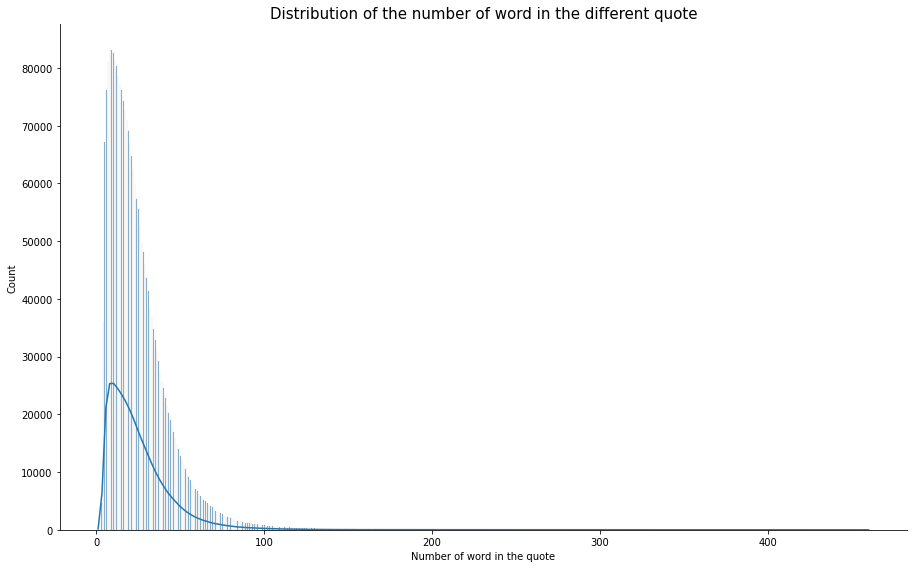

In [6]:
#See the distribution of the quotation length:
sns.displot(data= quotes_size, kde = True, height=8, aspect=1.6) 
sns.set_style('white')
plt.xlabel('Number of word in the quote')
plt.title("Distribution of the number of word in the different quote", x = 0.5, y = 1, fontsize = 15)
plt.tight_layout()
plt.show()

According to the distribution, the majority of the quotes are at most 100-words-long. In order to make sure that we analyse complete sentences, we are only going to keep sentences in a range 5 to 100 words long.


In [7]:
#According to the distribution of the number of word in the quotes, we can select only the quotes containg between 5 and 100 words to make sure that we analyse at least one complete sentence.

path_to_file = '/content/quotes-2020-clean.json.bz2'
path_to_out= '/content/quotes-2020-processed.json.bz2'
quotes_size1 =[]

with bz2.open(path_to_out, 'wb') as d_file:
    with bz2.open(path_to_file, 'rb') as s_file:
        for instance in s_file:
            instance = json.loads(instance) 

            if (5<= instance['size'] <= 100):
              #We only copy the line associated with the qotation size between 5 and 100:
                instance_out = instance

                size = len(instance_out['quotation'].split())
                quotes_size1.append(size)
                d_file.write((json.dumps(instance_out)+'\n').encode('utf-8'))

#Q75 = np.array(quotes_size).quantile(0.75)
#print(Q75)

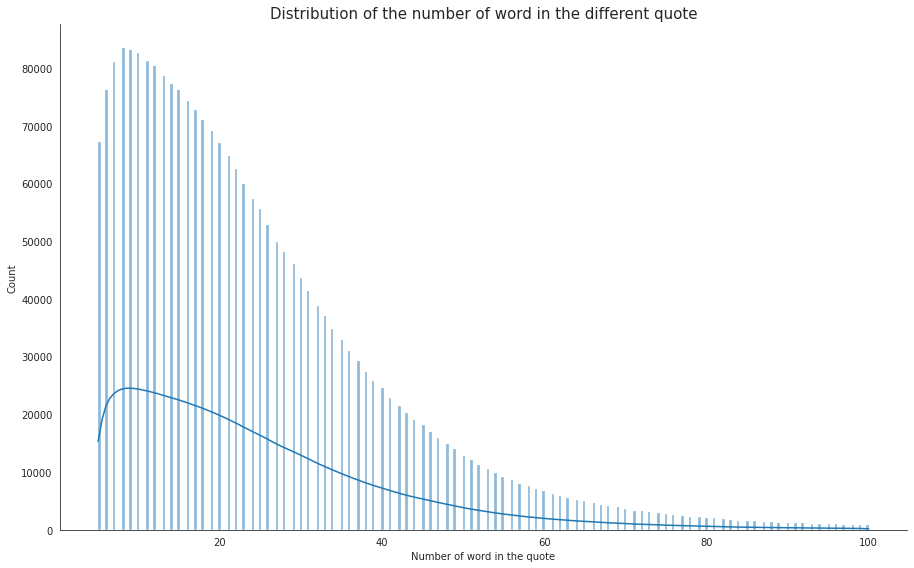

In [8]:
sns.displot(data= quotes_size1, kde = True, height=8, aspect=1.6) 
sns.set_style('white')
plt.xlabel('Number of word in the quote')
plt.title("Distribution of the number of word in the different quote", x = 0.5, y = 1, fontsize = 15)
plt.tight_layout()
plt.show()

## Second step : Pre-process the speakers attributes

During this analysis we are going to use some attributes of the speakers such as their gender, their qids ,their nationality and their US congress bio ID, if there is one.

These extracted attributes will be save in a new file.

The qIDs are kept so they will allow us to navigate between the quote file and the speaker file.

In [9]:
#This function converts date of birth into datetime format, and replaces 
#by np.nan if speaker was born before 1900
# According to the fact that we are performing a linguistic study, it is essential to make sure that the english spoken is fairily the same. 
#To do so, we decided to select the speakers of interest regarding the date of birth. 
#Such processing makes sure that the speakers are contemporary and may speak similarily.
def dateofbirth(date):
  #Remove speakers who are born before JC
    if date[0] == '-' or date[1:5] == '0000': 
        date = np.nan
    else:
      #Notice here that we are only focusing on the year, this line will set the every birth days and months to first of january
        date = datetime.strptime(date[1:5], '%Y')
        if (date.year < 1900):
            date = np.nan
    return date

#This function removes QIDS found in the sorted data that are irrelevant for the analysis
def gender(id):
    #remove erkek (which is a last name), homosexuality 
    if id == 'Q106299064' or id == 'Q6636':
        return np.nan
    #replace male organism, cis male by male
    if id == 'Q44148' or id == 'Q15145778':
        return 'Q6581097'
    #same for female
    if id== 'Q43445' or id == 'Q15145779':
        return 'Q6581072'
    else :
        return id

#function returns true if us citizen
def us_to_bool(nat):
    if isinstance(nat, np.ndarray):
        return np.isin('Q30', nat)
    else : return False

#function returns true if in congress
def congress(id):
    if isinstance(id, str): return True
    else : return False


In [10]:

#files = pathlib.Path('./parquet').glob('part-*-0d587965-3d8f-41ce-9771-5b8c9024dce9-c000.snappy.parquet')
files = pathlib.Path("/content/drive/MyDrive/ADAprojet2021/Project datasets/speaker_attributes.parquet/").glob("part-*-0d587965-3d8f-41ce-9771-5b8c9024dce9-c000.snappy.parquet")
df = pd.DataFrame()
columns = ['id', 'label', 'gender','date_of_birth', 'nationality', 'US_congress_bio_ID']
for path in files:
    df = pd.concat([df, pd.read_parquet(path, columns = columns)], join='outer', ignore_index=True)
    df = df.drop_duplicates(subset='id', keep = False)

df.gender = df.gender.apply(lambda x: rem_mult(x))
df.gender = df.gender.apply(lambda x: gender(x))

df.date_of_birth = df.date_of_birth.apply(lambda x: rem_mult(x))

df = df.dropna(subset = ['id', 'gender','date_of_birth'])
df = df.astype({'gender': 'category'})

df.date_of_birth = df.date_of_birth.apply(lambda x: dateofbirth(x))
df = df.dropna(subset = ['date_of_birth'])

df.nationality = df.nationality.apply(lambda x: us_to_bool(x))
df.US_congress_bio_ID = df.US_congress_bio_ID.apply(lambda x: congress(x))


display(df)
print(df.memory_usage(deep=True))
genders = df.gender.unique()


path_to_out = '/content/drive/MyDrive/speaker_attributes_processed.json.bz2'
df.to_json(path_to_out, orient = 'records', compression = 'bz2') 

,id,label,gender,date_of_birth,nationality,US_congress_bio_ID
2,Q18933,Rhoda Griffis,Q6581072,1965-01-01 00:00:00,True,False
3,Q18953,Peter DeLuise,Q6581097,1966-01-01 00:00:00,True,False
4,Q18971,Arthur P. Jacobs,Q6581097,1922-01-01 00:00:00,True,False
8,Q19190,Rupert Grint,Q6581097,1988-01-01 00:00:00,False,False
9,Q19205,Rob Bourdon,Q6581097,1979-01-01 00:00:00,True,False
...,...,...,...,...,...,...
9055974,Q210228,Kozo Yuki,Q6581097,1979-01-01 00:00:00,False,False
9055975,Q210231,Hayato Sasaki,Q6581097,1982-01-01 00:00:00,False,False
9055976,Q210284,Marinaldo Cícero da Silva,Q6581097,1986-01-01 00:00:00,False,False
9055978,Q210462,Christina Hendricks,Q6581072,1975-01-01 00:00:00,True,False


Index                  25786312
id                    211539869
label                 238764324
gender                  3225420
date_of_birth         180504184
nationality             3223289
US_congress_bio_ID      3223289
dtype: int64


Since we are doing an observationnal study, it is important to have a great notion of the distribution according to the different features. 

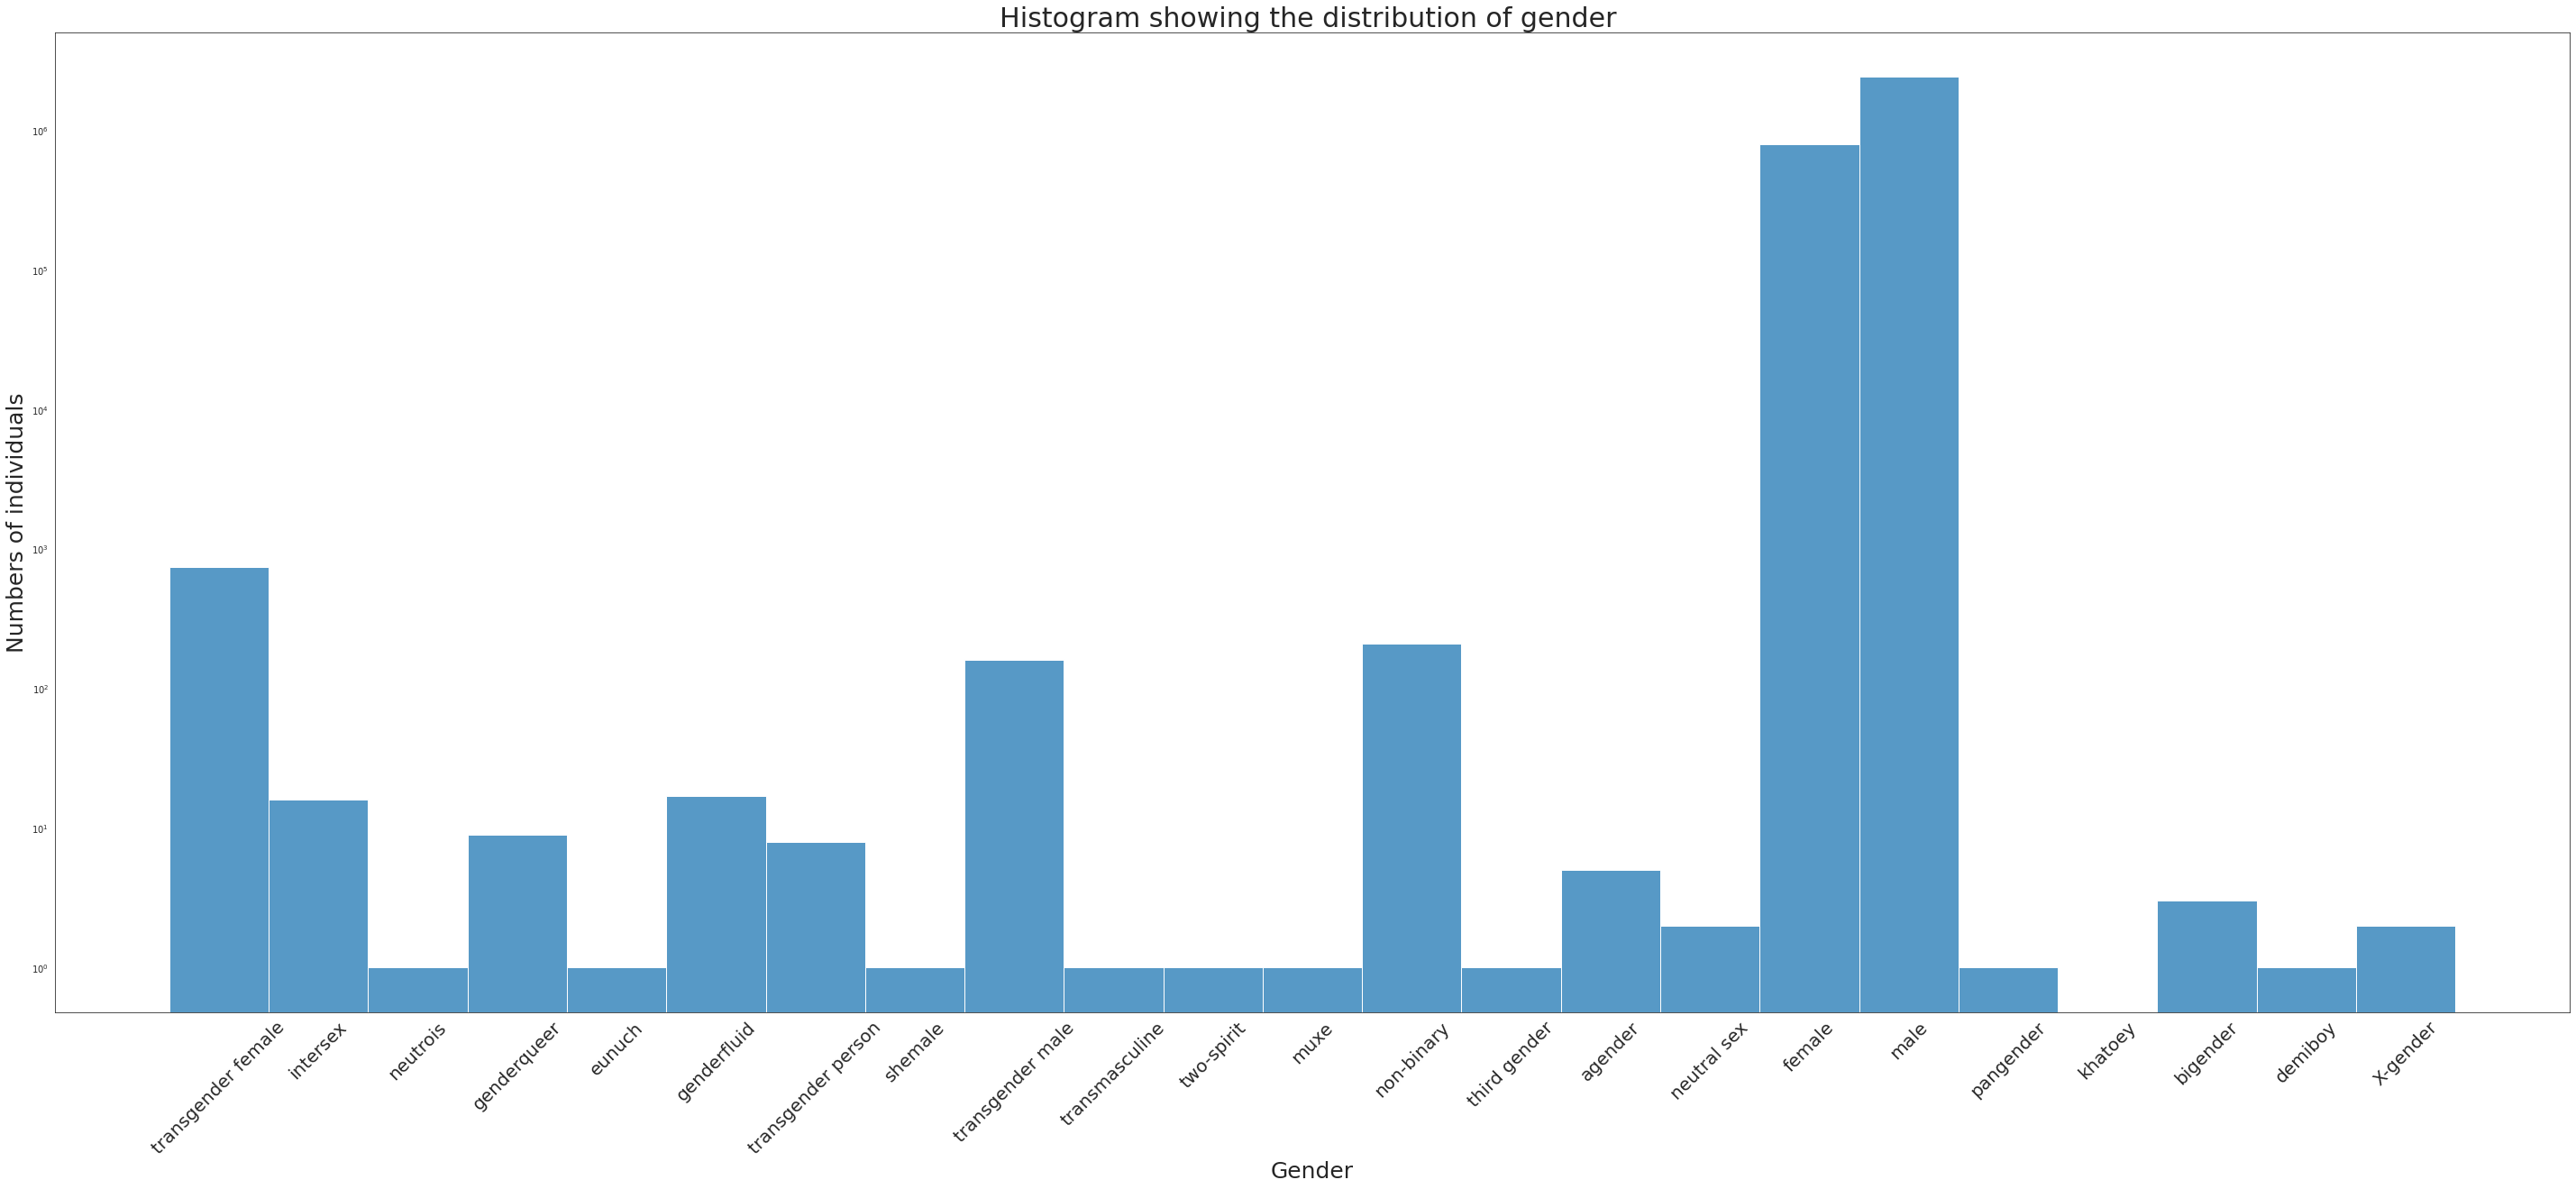

In [11]:
plt.figure(figsize=(50,20))
sns.histplot(df.gender)
plt.title("Histogram showing the distribution of gender ", fontsize=30)
plt.xlabel("Gender", fontsize=25)
plt.ylabel("Numbers of individuals", fontsize=25)
plt.yscale('log')
labels = ['transgender female', 'intersex', 'neutrois', 'genderqueer', 'eunuch', 'genderfluid', 'transgender person', 'shemale',
          'transgender male', 'transmasculine', 'two-spirit', 'muxe', 'non-binary', 'third gender', 'agender', 'neutral sex',
         'female', 'male', 'pangender', 'khatoey', 'bigender', 'demiboy', 'X-gender']
plt.xticks(ticks = np.arange(23), labels = labels, rotation=45, fontsize=20)
plt.show()

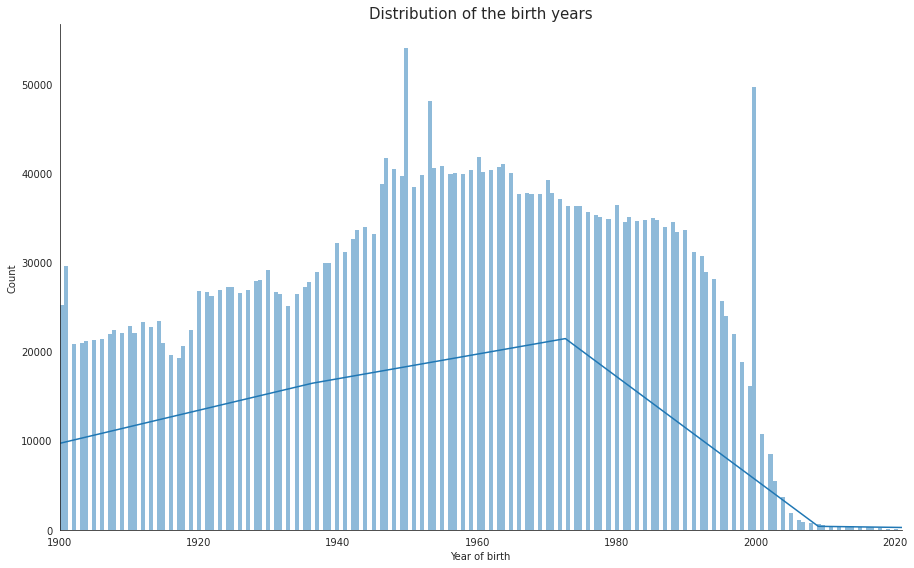

In [12]:

x = []
for i in df.date_of_birth:
  x.append(i.year)

sns.displot(data=x, kde = True, height=8, aspect=1.6) 
sns.set_style('white')
plt.xlabel('Year of birth')
plt.xlim(1900,2021)
plt.title("Distribution of the birth years", x = 0.5, y = 1, fontsize = 15)
plt.tight_layout()
plt.show()